<a href="https://colab.research.google.com/github/lovecrushfamily/PyTorch_Learning/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vision Transformer (Paper Replicating )

- ***Creating ViT from scratch using PyTorch***

### *Import libraries*

In [ ]:
# Code for colab requirements (colab's not installed torchinfo yet)
try:
    from torchinfo import summary
    print("torchinfo is already installed.")
except ImportError:
    print("torchinfo is not installed. Installing...")
    !pip install torchinfo==1.7.3
    from torchinfo import summary
    print("torchinfo has been installed.")

In [7]:
import torch                            # Core pytorch for tensor operator
import torch.nn as nn                   # Neural network module (layers, loss_function,..)
import torch.optim as optim             # optimization algorithms (SDG, RMSprop, Adam,...)
import torch.nn.functional as F         # Functional operations (activations, pooling,..)
import torch.utils.data as data         # Dataset handling and batching

import torchvision                                  # Computer vision utilities and pre-trained models
from torchvision import models
from torchvision import transforms                  # Image processing and augmentation
from torchvision import datasets                    # Image processing and augmentation
from torchvision.datasets import CIFAR100           # common CV datasets
from torchvision.models import resnet50             # Pre-trained model supported in PyTorch
from torchvision.models import ViT_B_16_Weights
from torchvision.models import vit_b_16


f"Torch version: {torch.__version__}", "^",\
f"Torchvision version: {torchvision.__version__}"

"""
A series of helper functions used throughout the course.
If a function gets defined once and could be used over and over, it'll go in here.
"""
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from pathlib import Path
import requests
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import time
import sys
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")


### *Diagnostic Code*

In [8]:
import torch.version

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device name: {torch.cuda.get_device_name()}")
print(f"Using device: {device}")
print(f"Cuda version: {torch.version.cuda}")

Device name: Tesla T4
Using device: cuda
Cuda version: 12.4


### *Get the data*

In [9]:

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

### *Set up directories*

In [10]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### *Prepare transform for Image*

In [11]:
IMG_SIZE =224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### *Create a Dataset and DataLoader*

In [12]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = data.DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = data.DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d726c15dbd0>,
 ['pizza', 'steak', 'sushi'])

### *Visualize single Image*

In [13]:
image_batch, label_batch = next(iter(train_dataloader))     # Get a batches of image
image, label = image_batch[0], label_batch[0]

image.shape, label



(torch.Size([3, 224, 224]), tensor(1))

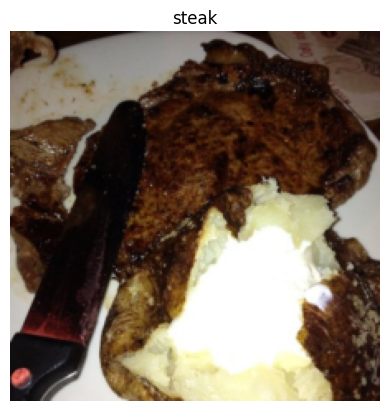

In [14]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Patches Embedding

- Split data into patches

- Creating class position and embedding

In [69]:
# Create example value
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2 )
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}) : {number_of_patches}")


Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16) : 196


In [16]:

# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


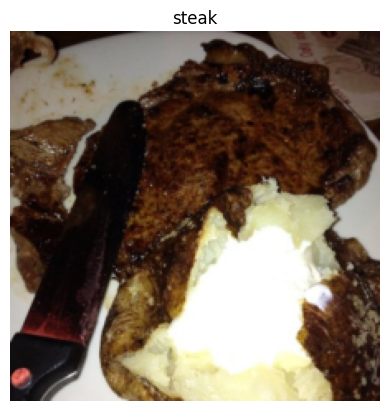

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

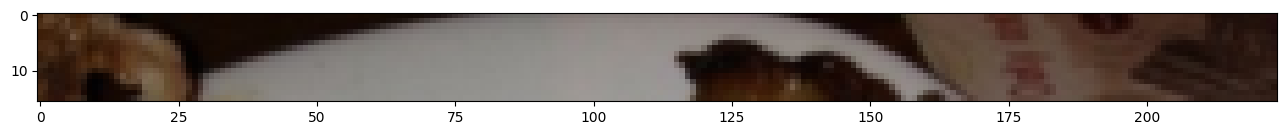

In [18]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


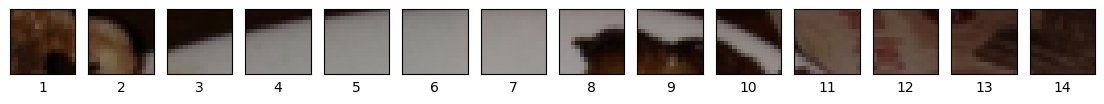

In [19]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

### *Image patchified*

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


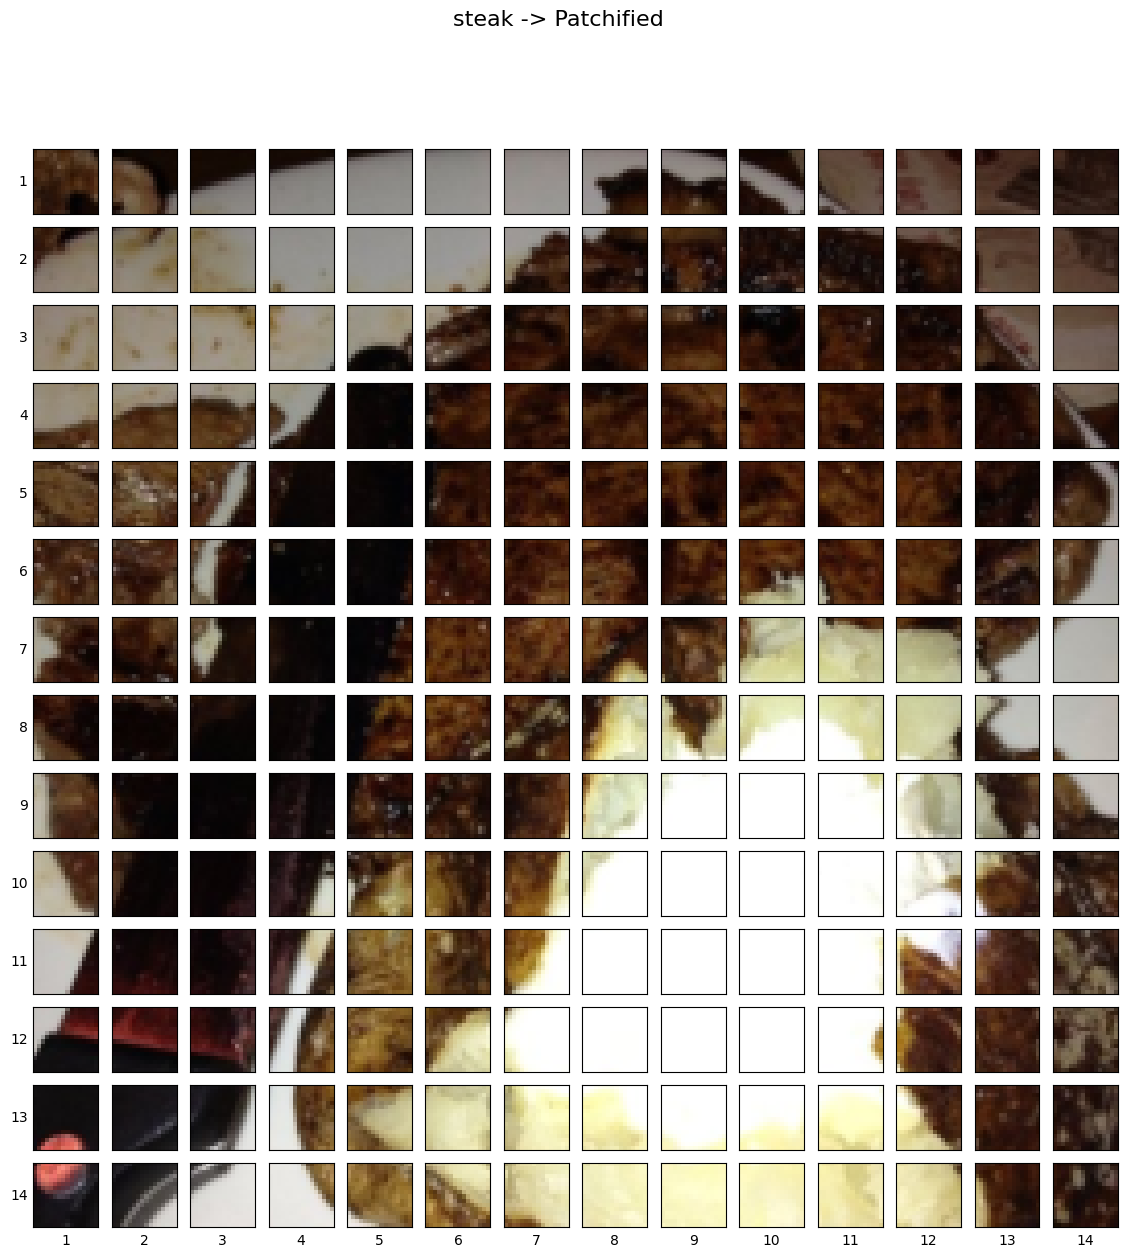

In [20]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,  # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
# iterate through height
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    # iterate through width
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,  # iterate through height
                                        patch_width:patch_width+patch_size,  # iterate through width
                                        :])  # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [21]:
# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

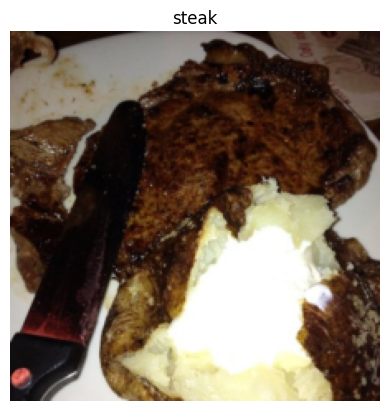

In [22]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [23]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


*torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]*

### *Visualize convolutional feature map*

Showing random convolutional feature maps from indexes: [194, 440, 547, 145, 457]


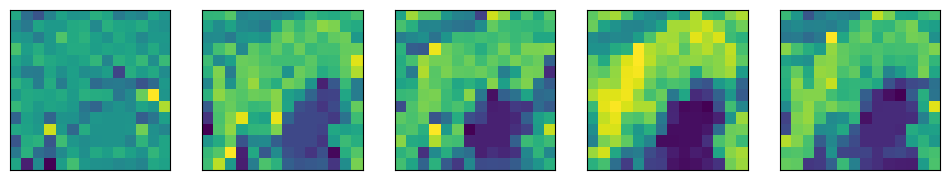

In [24]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [25]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-3.3669e-02, -1.0087e-01, -6.5023e-02, -1.1749e-01, -2.4175e-01,
           -2.1667e-01, -2.2344e-01, -2.6570e-01, -8.4948e-02, -2.6265e-02,
           -8.6815e-02, -8.5636e-02, -1.4362e-01, -3.1455e-02],
          [-7.5630e-02, -1.4600e-01, -2.1283e-01, -2.1086e-01, -2.2034e-01,
           -1.9565e-01, -5.3169e-02,  2.8428e-02, -5.9422e-02, -5.1138e-02,
           -9.9728e-02,  3.0964e-02, -9.1795e-02, -6.8575e-02],
          [-2.2427e-01, -2.1844e-01, -2.3066e-01, -2.7406e-01, -8.6659e-02,
            8.1965e-02, -2.4668e-02, -3.1296e-02, -9.0800e-02, -4.4787e-02,
           -1.6866e-02, -1.3277e-02, -5.2167e-02, -1.1005e-01],
          [-5.6330e-02, -2.0358e-01, -1.4136e-01, -1.7848e-01,  9.0207e-03,
            4.3127e-02,  4.2425e-03, -2.8682e-02, -4.7798e-02, -2.8025e-02,
           -3.5096e-02, -1.8466e-02, -5.8717e-03, -1.1724e-01],
          [-9.0856e-02,  2.0697e-02, -1.2826e-01, -1.5488e-02, -2.6492e-04,
            1.8048e-02, -1.8007e-02, -2.6848e-02, -1.0581e-0

### *Flattening the patch embedding*

In [26]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


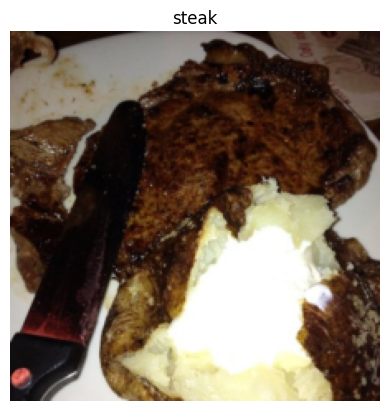

In [70]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


In [28]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


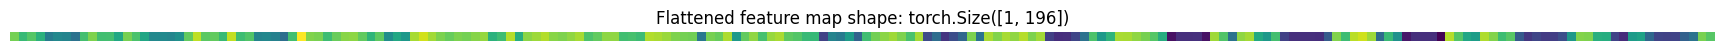

In [29]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);


*Linear Projection of Flatten Patches*

In [30]:
# See the flattened feature map as a tensor
single_flattened_feature_map, \
    single_flattened_feature_map.requires_grad \
        , single_flattened_feature_map.shape

(tensor([[-3.3669e-02, -1.0087e-01, -6.5023e-02, -1.1749e-01, -2.4175e-01,
          -2.1667e-01, -2.2344e-01, -2.6570e-01, -8.4948e-02, -2.6265e-02,
          -8.6815e-02, -8.5636e-02, -1.4362e-01, -3.1455e-02, -7.5630e-02,
          -1.4600e-01, -2.1283e-01, -2.1086e-01, -2.2034e-01, -1.9565e-01,
          -5.3169e-02,  2.8428e-02, -5.9422e-02, -5.1138e-02, -9.9728e-02,
           3.0964e-02, -9.1795e-02, -6.8575e-02, -2.2427e-01, -2.1844e-01,
          -2.3066e-01, -2.7406e-01, -8.6659e-02,  8.1965e-02, -2.4668e-02,
          -3.1296e-02, -9.0800e-02, -4.4787e-02, -1.6866e-02, -1.3277e-02,
          -5.2167e-02, -1.1005e-01, -5.6330e-02, -2.0358e-01, -1.4136e-01,
          -1.7848e-01,  9.0207e-03,  4.3127e-02,  4.2425e-03, -2.8682e-02,
          -4.7798e-02, -2.8025e-02, -3.5096e-02, -1.8466e-02, -5.8717e-03,
          -1.1724e-01, -9.0856e-02,  2.0697e-02, -1.2826e-01, -1.5488e-02,
          -2.6492e-04,  1.8048e-02, -1.8007e-02, -2.6848e-02, -1.0581e-02,
           9.8051e-03, -7

### *Turning the ViT patch embedding layer into PyTorch Module*

In [31]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [32]:


# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [33]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)

summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## Class Token Embedding

In [34]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.1250,  0.0710, -0.2216,  ...,  0.0643,  0.0043, -0.0233],
         [ 0.2452,  0.0522, -0.0915,  ...,  0.1960, -0.1776, -0.1004],
         [ 0.1956, -0.0186, -0.2687,  ...,  0.0806, -0.1503,  0.1184],
         ...,
         [ 0.5034,  0.2442, -0.7803,  ...,  0.3742, -0.2982, -0.1425],
         [ 0.1707,  0.0432, -0.2606,  ...,  0.1193, -0.1379,  0.0419],
         [ 0.1601,  0.0623, -0.2771,  ...,  0.0830, -0.0021, -0.0153]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### *Create learnable embedding for the class token*

- Demonstration purpose

In [35]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


### *Add class token embedding to the front of patch embedding*

In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.1250,  0.0710, -0.2216,  ...,  0.0643,  0.0043, -0.0233],
         [ 0.2452,  0.0522, -0.0915,  ...,  0.1960, -0.1776, -0.1004],
         ...,
         [ 0.5034,  0.2442, -0.7803,  ...,  0.3742, -0.2982, -0.1425],
         [ 0.1707,  0.0432, -0.2606,  ...,  0.1193, -0.1379,  0.0419],
         [ 0.1601,  0.0623, -0.2771,  ...,  0.0830, -0.0021, -0.0153]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


*Reviewing what we've done to create the learnable class token, we start with a sequence of image patch embeddings created by PatchEmbedding() on single image, we then created a learnable class token with one value for each of the embedding dimensions and then prepended it to the original sequence of patch embeddings. Note: Using torch.ones() to create the learnable class token is mostly for demonstration purposes only, in practice, you'd likely create it with torch.randn().*

## Create Position Embedding

In [37]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


*Note: Only creating the position embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the position embedding with torch.randn() (start with a random number and improve via gradient descent).*

In [38]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.1250, 1.0710, 0.7784,  ..., 1.0643, 1.0043, 0.9767],
         [1.2452, 1.0522, 0.9085,  ..., 1.1960, 0.8224, 0.8996],
         ...,
         [1.5034, 1.2442, 0.2197,  ..., 1.3742, 0.7018, 0.8575],
         [1.1707, 1.0432, 0.7394,  ..., 1.1193, 0.8621, 1.0419],
         [1.1601, 1.0623, 0.7229,  ..., 1.0830, 0.9979, 0.9847]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### *Image to Embedding*

In [39]:
# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


- *Mapping equation 1 from the ViT paper to our PyTorch code. This is the essence of paper replicating, taking a research paper and turning it into usable code.*

## Multi-Head Attention (MSA)

In [40]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [41]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## Multilayer Perceptron

In [42]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [43]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## Transformer Encoder

- *One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.*

- *Note: The iconic computer vision architecture "ResNet" is named so because of the introduction of residual connections. You can find many pretrained versions of ResNet architectures in torchvision.models.*

### *Followed these steps (manually)*
- Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.

- Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.

- Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate
parameters.
- Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.

- Create a forward() method for our TransformerEncoderBlock class.

- Create a residual connection for the MSA block (for equation 2).

- Create a residual connection for the MLP block (for equation 3).


In [44]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

### *Summary*

In [45]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

- *Note: Just because our input to the Transformer Encoder block has the same shape at the output of the block doesn't mean the values weren't manipulated, the whole goal of the Transformer Encoder block (and stacking them together) is to learn a deep representation of the input using the various layers in between.*

### *Transformer Encoder Layer (PyTorch Built-in )*

In [46]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [47]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## Vision Transformer

In [48]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""

    def __init__(self,                                         # 2. Initialize the class with hyperparameters from Table 1 and Table 3
                 img_size:int=224,                             # Training resolution from Table 3 in ViT paper
                 in_channels:int=3,                            # Number of channels in input image
                 patch_size:int=16,                            # Patch size
                 num_transformer_layers:int=12,                # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768,                        # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072,                            # MLP size from Table 1 for ViT-Base
                 num_heads:int=12,                             # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0,                         # Dropout for attention projection
                 mlp_dropout:float=0.1,                        # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1,                  # Dropout for patch and position embeddings
                 num_classes:int=1000):                        # Default for ImageNet but can customize this

        super().__init__()                                     # don't forget the super().__init__()!
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."     # 3. Make the image size is divisible by the patch size
        self.num_patches = (img_size * img_size) // patch_size**2                                                                               # 4. Calculate number of patches (height * width/patch^2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),                                                              # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),                                          # 6. Create learnable position embedding
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)                                                                                # 7. Create embedding dropout value
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,                                                                          # 8. Create patch embedding layer
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)



        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,                                         # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
                                                                            num_heads=num_heads,                                                # Note: The "*" means "all"
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(                                                                                                        # 10. Create classifier head
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):                                                       # 11. Create a forward() method
        batch_size = x.shape[0]                                                 # 12. Get batch size
                                                                                # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)           # "-1" means to infer the dimension (try this line on its own)

        x = self.patch_embedding(x)                                             # 14. Create patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)                                  # 15. Concat class embedding and patch embedding (equation 1)
        x = self.position_embedding + x                                         # 16. Add position embedding to patch embedding (equation 1)
        x = self.embedding_dropout(x)                                           # 17. Run embedding dropout (Appendix B.1)
        x = self.transformer_encoder(x)                                         # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.classifier(x[:, 0])                                            # 19. Put 0 index logit through classifier (equation 4)

        return x

In [49]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [50]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.2050, -0.0936, -0.8706]], grad_fn=<AddmmBackward0>)

### *Summary*

In [51]:

summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

### *Training*

In [52]:
def format_time(seconds: float) -> str:                          # Time formatting helper
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return f'{h:02d}:{m:02d}:{s:02d}'

def train_step(model: nn.Module,
               dataloader: data.DataLoader,
               loss_fn: nn.Module,
               optimizer: optim.Optimizer,
               device: torch.device,
               epoch: int,
               total_epochs: int,
               start_time: float) -> Tuple[float, float]:
    model.train()                                            # Set model to training mode
    train_loss, train_acc = 0, 0                             # Initialize training metrics
    total_steps = len(dataloader)                            # Total batches in epoch

    for batch, (X, y) in enumerate(dataloader):              # Training loop
        X, y = X.to(device), y.to(device)                    # Move data to device
        y_pred = model(X)                                    # Forward pass
        loss = loss_fn(y_pred, y)                            # Calculate loss
        train_loss += loss.item()                            # Accumulate loss

        optimizer.zero_grad()                                # Clear gradients
        loss.backward()                                      # Backward pass
        optimizer.step()                                     # Update weights

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  # Calculate predictions
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)         # Accumulate accuracy

        progress = (batch + 1) / total_steps                 # Calculate progress
        elapsed = time.time() - start_time                   # Time elapsed
        eta = elapsed * (total_steps - (batch + 1)) / max(batch + 1, 1)  # Estimated time remaining
        bar_length = 30                                      # Progress bar length
        filled = int(bar_length * progress)                  # Filled portion of bar
        bar = '=' * filled + '-' * (bar_length - filled)    # Create bar string

        metrics = {                                          # Current metrics
            'loss': train_loss/(batch + 1),
            'acc': train_acc/(batch + 1),
            'lr': optimizer.param_groups[0]['lr']
        }
        metrics_str = ' - '.join(f'{k}: {v:.4f}' for k, v in metrics.items())  # Format metrics

        status = f'Epoch {epoch+1}/{total_epochs} [{bar}] {progress:.0%} '  # Build status string
        status += f'[{format_time(elapsed)}<{format_time(eta)}] {metrics_str}'
        sys.stdout.write(f'\r{status}')                      # Update progress bar
        sys.stdout.flush()

    train_loss = train_loss / total_steps                    # Average training metrics
    train_acc = train_acc / total_steps
    sys.stdout.write('\n')                                   # New line after epoch
    sys.stdout.flush()

    return train_loss, train_acc

def test_step(model: nn.Module,
              dataloader: data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()                                             # Set model to evaluation mode
    test_loss, test_acc = 0, 0                               # Initialize testing metrics

    with torch.inference_mode():                             # Inference mode for testing
        for X, y in dataloader:                              # Testing loop
            X, y = X.to(device), y.to(device)                # Move data to device
            test_pred_logits = model(X)                      # Forward pass
            test_loss += loss_fn(test_pred_logits, y).item() # Accumulate loss
            test_pred_labels = test_pred_logits.argmax(dim=1)  # Calculate predictions
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)  # Accumulate accuracy

    test_loss = test_loss / len(dataloader)                  # Average testing metrics
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train_model(model: nn.Module,
                train_dataloader: data.DataLoader,
                test_dataloader: data.DataLoader,
                optimizer: optim.Optimizer,
                loss_fn: nn.Module,
                epochs: int,
                device: torch.device,
                seed: int = 16) -> Dict[str, List]:
    torch.manual_seed(seed)                                  # Set seed for reproducibility
    torch.cuda.manual_seed(seed)                             # Set CUDA seed for GPU operations

    results = {"train_loss": [],                             # Initialize results dictionary
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    start_time = time.time()                                 # Track total training time

    for epoch in range(epochs):                              # Main epoch loop
        train_loss, train_acc = train_step(                  # Perform training step
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            epoch=epoch,
            total_epochs=epochs,
            start_time=start_time
        )

        test_loss, test_acc = test_step(                     # Perform testing step
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        results["train_loss"].append(train_loss)             # Store results
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [53]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = train_model(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

Epoch 1/100 [==============================] 100% [00:00:07<00:00:00] loss: 3.5723 - acc: 0.2891 - lr: 0.0030
Epoch 2/100 [==============================] 100% [00:00:15<00:00:00] loss: 1.4674 - acc: 0.2773 - lr: 0.0030
Epoch 3/100 [==============================] 100% [00:00:24<00:00:00] loss: 1.2423 - acc: 0.4102 - lr: 0.0030
Epoch 4/100 [==============================] 100% [00:00:32<00:00:00] loss: 1.2609 - acc: 0.2539 - lr: 0.0030
Epoch 5/100 [==============================] 100% [00:00:41<00:00:00] loss: 1.2601 - acc: 0.2734 - lr: 0.0030
Epoch 6/100 [==============================] 100% [00:00:49<00:00:00] loss: 1.0792 - acc: 0.3984 - lr: 0.0030
Epoch 7/100 [==============================] 100% [00:00:58<00:00:00] loss: 1.1287 - acc: 0.4023 - lr: 0.0030
Epoch 8/100 [==============================] 100% [00:01:07<00:00:00] loss: 1.1584 - acc: 0.3203 - lr: 0.0030
Epoch 9/100 [==============================] 100% [00:01:16<00:00:00] loss: 1.2058 - acc: 0.4258 - lr: 0.0030
Epoch 10/1

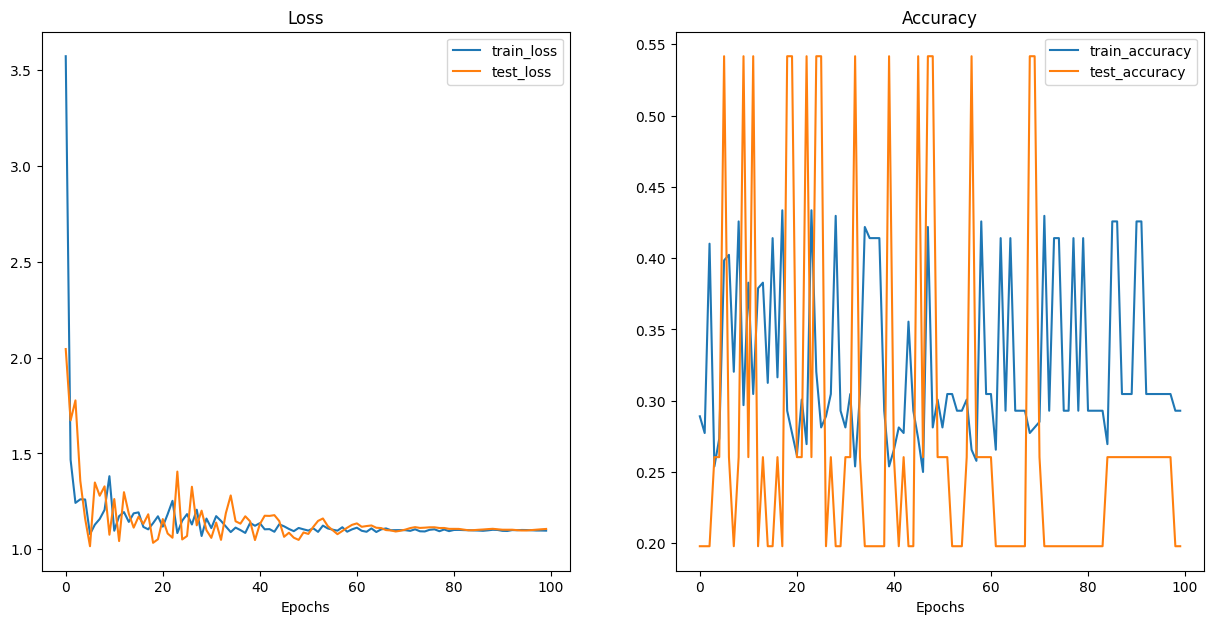

In [54]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [55]:
from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

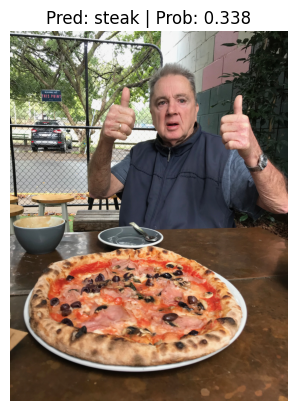

In [56]:

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

## Pre-trained ViT PyTorch

- *vision transformer b 16*

In [57]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT
pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights).to(device)



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 109MB/s] 


### *Freeze the base parameters*

In [58]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


### *Change the classifier head*

In [59]:
# Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### *Summarize model*

In [60]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]         [32, 3]                   768                       Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder (encoder)                                          [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout (dropout)                                     [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential (layers)                                   [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]            [32, 197, 768]            (7,087,872)   

In [61]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [62]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [63]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### *Setup DataLoader*

In [64]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = data.DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = data.DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


In [71]:
train_dataloader_pretrained, \
    test_dataloader_pretrained, \
        class_names = create_dataloaders(train_dir=train_dir,
                                        test_dir=test_dir,
                                        transform=pretrained_vit_transforms,
                                        batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### *Trainin*

In [66]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = train_model(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

Epoch 1/10 [==============================] 100% [00:00:03<00:00:00] loss: 0.7908 - acc: 0.7305 - lr: 0.0010
Epoch 2/10 [==============================] 100% [00:00:07<00:00:00] loss: 0.3246 - acc: 0.9531 - lr: 0.0010
Epoch 3/10 [==============================] 100% [00:00:13<00:00:00] loss: 0.2117 - acc: 0.9492 - lr: 0.0010
Epoch 4/10 [==============================] 100% [00:00:17<00:00:00] loss: 0.1508 - acc: 0.9609 - lr: 0.0010
Epoch 5/10 [==============================] 100% [00:00:22<00:00:00] loss: 0.1340 - acc: 0.9648 - lr: 0.0010
Epoch 6/10 [==============================] 100% [00:00:27<00:00:00] loss: 0.1100 - acc: 0.9727 - lr: 0.0010
Epoch 7/10 [==============================] 100% [00:00:31<00:00:00] loss: 0.0955 - acc: 0.9766 - lr: 0.0010
Epoch 8/10 [==============================] 100% [00:00:36<00:00:00] loss: 0.0830 - acc: 0.9805 - lr: 0.0010
Epoch 9/10 [==============================] 100% [00:00:41<00:00:00] loss: 0.0722 - acc: 0.9844 - lr: 0.0010
Epoch 10/10 [======

### *Save models*

In [72]:

def save_model(model: nn.Module,
               target_dir: str = "saved_models",
               model_name: str = None) -> None:

    model_name = model._get_name() if model_name == None else model_name
    timestamp = datetime.now().strftime("%d_%m_%Y")         # Format date as day_month_year
    full_model_name = f"{model_name}_{timestamp}.pth"       # Combine name with timestamp
    target_dir_path = Path(target_dir)                      # Convert to Path object
    target_dir_path.mkdir(parents=True, exist_ok=True)      # Create directory if needed
    model_save_path = target_dir_path / full_model_name     # Complete file path
    # Save the model
    print(f"[INFO] Saving model to: {model_save_path}")     # Log save operation
    torch.save(obj=model.state_dict(), f=model_save_path)   # Save model state_dict

# Save the model
save_model(model=pretrained_vit, model_name="pretrained_ViT")

[INFO] Saving model to: saved_models/pretrained_ViT_24_03_2025.pth


## Make prediction

data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


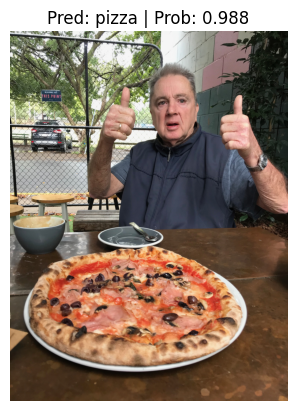

In [68]:
# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)